In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.0.0-alpha0'

## Executing Ops Eagerly

In [3]:
x = [[2,]]
m = tf.square(x)
print(m)

tf.Tensor([[4]], shape=(1, 1), dtype=int32)


In [4]:
m.numpy()

array([[4]], dtype=int32)

In [5]:
a = tf.constant([[1, 2],
                 [3, 4]])
b = tf.constant([[2, 1],
                 [3, 4]])
ab = tf.matmul(a, b)
print('a * b = \n', ab.numpy())

a * b = 
 [[ 8  9]
 [18 19]]


## Constants and Variables

In [6]:
a = tf.constant([[2, 3]])
print(a)

tf.Tensor([[2 3]], shape=(1, 2), dtype=int32)


In [7]:
try:
    a.assign(2.)
except:
    print('Exception raised')

Exception raised


In [8]:
v = tf.Variable(5.)
print('Old value for v =', v.numpy())
v.assign(2.)
print('New value for v =', v.numpy())

Old value for v = 5.0
New value for v = 2.0


In [9]:
v.assign(2.)
print('value     : ', v.numpy())
print('increment : ', v.assign_add(1.).numpy())
print('decrement : ', v.assign_sub(1.).numpy())

value     :  2.0
increment :  3.0
decrement :  2.0


In [10]:
print('name  : ', v.name)
print('type  : ', v.dtype)
print('shape : ', v.shape)
print('device: ', v.device)

name  :  Variable:0
type  :  <dtype: 'float32'>
shape :  ()
device:  /job:localhost/replica:0/task:0/device:GPU:0


## Gradient Evaluation

In [11]:
w = tf.Variable(2.0)

#watch the gradient of the loss operation
with tf.GradientTape() as tape:
  loss = w * w

grad = tape.gradient(loss, w)
print('The gradient of w^2 at {} is {}'.format(w.numpy(), grad.numpy()))

The gradient of w^2 at 2.0 is 4.0


In [12]:
def sigmoid(x):
    return 1/(1+tf.exp(-x))

In [13]:
x = tf.Variable(0.)

with tf.GradientTape() as tape:
    y = sigmoid(x)
    
print('The gradient of the sigmoid function at 0.0 is ', tape.gradient(y,x).numpy())

The gradient of the sigmoid function at 0.0 is  0.25


In [14]:
def log(x):
    return tf.math.log(x)

In [15]:
x = tf.Variable(1.)

with tf.GradientTape() as t1:
    with tf.GradientTape() as t2:
        y = log(x)
    dx = t2.gradient(y, x)
dx2 = t1.gradient(dx, x)

print('The first derivative of log at x = 1 is ', dx.numpy())
print('The second derivative of log at x = 1 is ', dx2.numpy())

The first derivative of log at x = 1 is  1.0
The second derivative of log at x = 1 is  -1.0


## Custom Gradients

In [16]:
def logexp(x):
    return tf.math.log(1 + tf.exp(x))

In [17]:
def grad_logexp(x):
    with tf.GradientTape() as tape:
        y = logexp(x)
    dx = tape.gradient(y, x)
    return dx

In [18]:
x = tf.Variable(0.)
print('The gradient at x = 0 is ', grad_logexp(x).numpy())
x = tf.Variable(100.)
print('The gradient at x = 100 is ', grad_logexp(x).numpy())

The gradient at x = 0 is  0.5
The gradient at x = 100 is  nan


In [19]:
@tf.custom_gradient
def logexp_stable(x):
    e = tf.exp(x)
    def grad(dy):
        return dy * (1 - 1 / (1 + e))
    return tf.math.log(1 + e), grad

In [20]:
def grad_logexp(x):
    with tf.GradientTape() as tape:
        y = logexp_stable(x)
    dx = tape.gradient(y, x)
    return dx

In [21]:
x = tf.Variable(100.)
print('The gradient at x = 100 is ', grad_logexp(x).numpy())

The gradient at x = 100 is  1.0


## tf.function

In [22]:
@tf.function
def g(x):
    y = tf.reduce_sum(x)
    if y > 0:
        return y
    return tf.abs(y)

In [23]:
g(-3)

<tf.Tensor: id=183, shape=(), dtype=int32, numpy=3>

In [24]:
m = tf.keras.metrics.Mean("loss")

m(2)
m(4)

print('The mean loss is ', m.result().numpy())

The mean loss is  3.0


In [25]:
m.reset_states()
print('The mean loss is ', m.result().numpy())

The mean loss is  0.0


## Linear Regression

In [26]:
NUM_EXAMPLES = 1000

X = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
y = X * 3 + 2 + noise

W = tf.Variable(0.)
b = tf.Variable(0.)

train_steps = 200
learning_rate = 0.01

for i in range(train_steps):
    with tf.GradientTape() as tape:
        
        yhat = X * W + b
        
        error = yhat - y
        loss = tf.reduce_mean(tf.square(error))
        
    dW, db = tape.gradient(loss, [W, b])
    
    W.assign_sub(dW * learning_rate)
    b.assign_sub(db * learning_rate)
    
    if i % 20 == 0:
        print("Loss at step {:03d}: {:.3f}".format(i, loss))
        
print("W : {}, b = {}".format(W.numpy(), b.numpy()))

Loss at step 000: 13.920
Loss at step 020: 6.751
Loss at step 040: 3.551
Loss at step 060: 2.123
Loss at step 080: 1.485
Loss at step 100: 1.201
Loss at step 120: 1.074
Loss at step 140: 1.017
Loss at step 160: 0.992
Loss at step 180: 0.980
W : 2.923673391342163, b = 1.991908311843872


## Dataset Processing and Augmentation

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [28]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

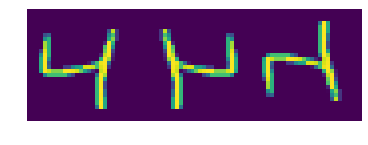

In [29]:
img = x_train[2:3]
img = np.expand_dims(img, -1)

# flipping horizontally
img1 = tf.image.flip_left_right(img)

# flipping vertically
img2 = tf.image.flip_up_down(img)

plt.axis('off')
plt.imshow(tf.concat([img, img1, img2], axis = 2).numpy().squeeze())
plt.show()

In [30]:
def pre_process(x, y):
    # normalize and expand
    x = tf.cast(x, tf.float32)/255.
    x = tf.expand_dims(x, -1)
    
    # cast the labels
    y = tf.cast(y, tf.int32)
    return x, y

def create_dataset(x, y):
    # convert to tensors and shuffle
    dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(len(x)-1)
    
    # extract batches
    dataset = dataset.batch(32)
    
    # preprocess the batch
    dataset = dataset.map(pre_process, num_parallel_calls=4)
    
    return dataset

In [31]:
train_dataset = create_dataset(x_train, y_train)
test_dataset = create_dataset(x_test, y_test)

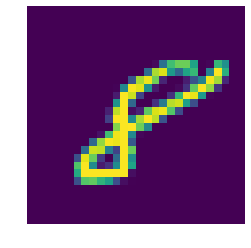

In [32]:
for x, y in train_dataset:
    plt.imshow(x[0].numpy().squeeze())
    plt.axis('off')
    plt.show()
    break

## custom layers

In [33]:
initializer = tf.random_uniform_initializer()

In [34]:
x = tf.Variable(initializer(shape = (10,)))
print(x.numpy())

[-0.03533089  0.01183294 -0.03340511  0.03154682 -0.02579676 -0.03091618
  0.03413266 -0.04336311 -0.04530348 -0.038062  ]


In [35]:
from tensorflow.keras.layers import Layer

In [36]:
class Linear(Layer):
    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()
        
        # random initializer for the weights
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype='float32'),
            trainable=True)
        
        # zero initialized biases
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(units,), dtype='float32'),
            trainable=True)
        
    def call(self, inputs):
        # froward call
        return tf.matmul(inputs, self.w) + self.b

In [38]:
#create a simple linear layer that has 10 neorons and accept inputs of size 3
llayer = Linear(units = 10, input_dim = 3)

In [40]:
# forward call of batch of size 3
llayer(tf.ones((3, 3)))

<tf.Tensor: id=8597, shape=(3, 10), dtype=float32, numpy=
array([[ 0.01016862, -0.22906333,  0.01520133, -0.02347573,  0.07029915,
        -0.10171644,  0.05988783,  0.15682419, -0.1622899 ,  0.10910574],
       [ 0.01016862, -0.22906333,  0.01520133, -0.02347573,  0.07029915,
        -0.10171644,  0.05988783,  0.15682419, -0.1622899 ,  0.10910574],
       [ 0.01016862, -0.22906333,  0.01520133, -0.02347573,  0.07029915,
        -0.10171644,  0.05988783,  0.15682419, -0.1622899 ,  0.10910574]],
      dtype=float32)>

## End-to-End CNN Example

In [41]:
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

In [43]:
def create_model():
    model = Sequential()
    model.add(Convolution2D(filters = 16, kernel_size = 3, padding = 'same', input_shape = [28, 28, 1], activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=10,activation='softmax'))
    return model

### Create the model

In [44]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               156900    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

In [46]:
import numpy as np
model(np.zeros((10, 28, 28, 1), np.float32))

<tf.Tensor: id=8781, shape=(10, 10), dtype=float32, numpy=
array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32)>

### Design the loss function, Gradient and Accuracy metric

In [50]:
# evaluate the loss
def loss(y, yhat):
    # this applies the loss to sparse labels i.e not one hot encoded
    return tf.keras.losses.sparse_categorical_crossentropy(y, yhat)

# record the gradient with respect to the model variables
def grad(model, x, y):
    with tf.GradientTape() as tape:
        yhat = model(x)
        loss_value = loss(y, yhat)
    return tape.gradient(loss_value, model.trainable_variables)

# calcuate the accuracy of the model
def accuracy(y, yhat):
    # get the labels of the predicted values
    yhat = tf.argmax(yhat, 1).numpy()
    
    # get the labels of the true values
    y = y.numpy()
    return np.sum(y == yhat)/len(y)

### Intitalize the variables

In [51]:
# use Adam optimizer
optimizer = tf.keras.optimizers.Adam()

# record epoch loss and accuracy
loss_history = tf.keras.metrics.Mean('loss')
accuracy_history = tf.keras.metrics.Mean('accuracy')

# epochs
epochs = 3

### Training

In [53]:
for epoch in  range(1, epochs+1):
    for x, y in train_dataset:
        
        yhat = model(x)
        # Calculate derivatives of the input function with respect to its parameters
        grads = grad(model, x, y)
        
        # Apply the gradient to the model
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # record the current loss and accuracy
        loss_history(loss(y, yhat))
        accuracy_history(accuracy(y, yhat))
        
    print("epoch: {:d} Loss: {:.3f}, Acc: {:.3f}".format(epoch, loss_history.result(), accuracy_history.result()))
    
    # clear the history
    loss_history.reset_states()
    accuracy_history.reset_states()

epoch: 1 Loss: 0.103, Acc: 0.968
epoch: 2 Loss: 0.033, Acc: 0.989
epoch: 3 Loss: 0.023, Acc: 0.993


### Testing

In [54]:
accuracy_history.reset_states()
for x, y in test_dataset:
    # Calculate derivatives of the input function with respect to its parameters
    yhat = model(x)
    
    # record the current loss and accuracy
    accuracy_history(accuracy(y, yhat))
print("Acc: {:.2f}".format(accuracy_history.result()))

Acc: 0.99


## Save and Restore a Model

In [55]:
import os

# check if it exists
if os.path.isdir('model'):
    raise Exception('Folder exists !')
else:
    checkpoint_dir = 'model'
    os.mkdir(checkpoint_dir)
    
    # create a root for the checkpoint
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    root = tf.train.Checkpoint(optimizer=optimizer, model=model)
    
    # save the model
    root.save(file_prefix=checkpoint_prefix)

In [57]:
# create an empty model
model = create_model()

# create a checkpoint variable
root = tf.train.Checkpoint(optimizer=optimizer, model=create_model())

# restores the model
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

# retrieve the trained model
model = root.model